# Convolutional Neural Networks (ConvNets)

- Image convolution (Kernels)
- Convolutional neural networks
- Data augmentation
- Real-world CNNs
- Model interpretation
- Using pre-trained networks (transfer learning)



## 1. Kernels & Pooling

- [各种类型的卷积，你认全了吗？](https://blog.csdn.net/Together_CZ/article/details/115494176)

### Border effects (zero padding)

### Undersampling (striding)

### Dilated convolutions

### Max-pooling

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import pytorch_lightning as pl
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torchmetrics.functional import accuracy
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
import matplotlib.pyplot as plt

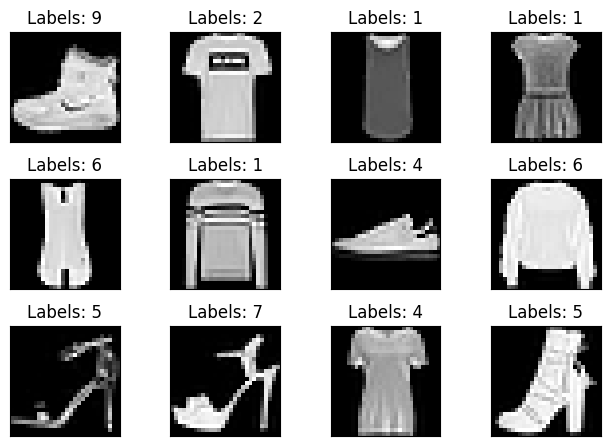

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


fmnist_train = torchvision.datasets.FashionMNIST(
    root="../Data/FMNIST", train=True, transform=transform, download=True
)

fmnist_test = torchvision.datasets.FashionMNIST(
    root="../Data/FMNIST", train=False, transform=transform, download=True
)


#fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout() # 自动调整子图参数，以使图像和标题不重叠，并使布局更紧凑
    plt.imshow(fmnist_train.data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(fmnist_test.targets[i]))
    plt.xticks([]) # 隐藏 x 轴和 y 轴的刻度，以便图像显示更整洁
    plt.yticks([])
plt.show()

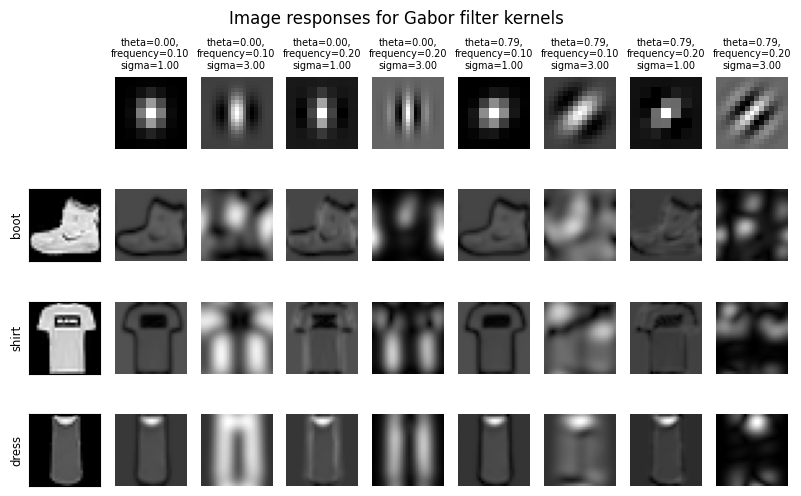

In [23]:
boot = fmnist_train[0][0].numpy().squeeze().reshape(28,28)
shirt = fmnist_train[1][0].numpy().squeeze().reshape(28,28)
dress = fmnist_train[2][0].numpy().squeeze().reshape(28,28)
image_names = ('boot', 'shirt', 'dress')
images = (boot, shirt, dress)


def magnitude(image, kernel):
    """ 
    计算 Gabor 滤波器对输入图像的响应幅度:
    该函数通过对图像进行归一化和卷积操作，最终返回 Gabor 滤波器对图像的响应幅度，
    常用于边缘检测和纹理分析等图像处理任务
    """
    image = (image - image.mean()) / image.std() # Normalize images
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def plot_filter_bank(images, fig_scale = 0.7):
    # Create a set of kernels, apply them to each image, store the results
    results = []
    kernel_params = []
    for theta in (0, 1):
        theta = theta / 4. * np.pi
        for frequency in (0.1, 0.2):
            for sigma in (1, 3):
                kernel = gabor_kernel(frequency, theta=theta,sigma_x=sigma,sigma_y=sigma)
                params = 'theta=%.2f,\nfrequency=%.2f\nsigma=%.2f' % (theta, frequency, sigma)
                kernel_params.append(params)
                results.append((kernel, [magnitude(img, kernel) for img in images]))

    # Plotting
    fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(14*fig_scale, 8*fig_scale))
    plt.gray()
    fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
    axes[0][0].axis('off') # 使第一个子图不显示坐标轴

    for label, img, ax in zip(image_names, images, axes[1:]):
        axs = ax[0]
        axs.imshow(img)
        axs.set_ylabel(label, fontsize=12*fig_scale)
        axs.set_xticks([]) # Remove axis ticks 
        axs.set_yticks([])
        
    # Plot Gabor kernel
    col = 1
    for label, (kernel, magnitudes), ax_col in zip(kernel_params, results, axes[0][1:]):
        ax_col.imshow(np.real(kernel), interpolation='nearest') # Plot kernel
        ax_col.set_title(label, fontsize=10*fig_scale)
        ax_col.axis('off')
        
        # Plot Gabor responses with the contrast normalized for each filter
        vmin = np.min(magnitudes)
        vmax = np.max(magnitudes)
        for patch, ax in zip(magnitudes, axes.T[col][1:]):
            ax.imshow(patch, vmin=vmin, vmax=vmax) # Plot convolutions
            ax.axis('off')
        col += 1
    
    plt.show()

plot_filter_bank(images)

## 2. ConvNets

Finding relationships between **individual pixels** and the **correct class** is hard; <p>

---> **Simplify** the problem by decomposing it into **smaller problems**:

- First, discover 'local' patterns (edges, lines, endpoints)

- Representing such local patterns as features makes it easier to learn from them

    - **Deeper** layers will do that for us

    - We could use convolutions, but how to **choose the filters**?


Instead of manually designing the filters, we can also ***learn*** them based on data:

- **Choose filter sizes (manually), initialize with small random weights**

- **Forward pass**: Convolutional layer slides the filter over the input, generates the output

- **Backward pass**: Update the filter weights according to the loss gradients

### 2.1 Feature Maps

在每个卷积层, 数据都是以三维形式存在的. 你可以把它看成许多个二维图片叠在一起, 其中每一个称为一个`feature map`. 在输入层, 如果是灰度图片, 那就只有一个feature map; 如果是彩色图片, 一般就是3个`feature map``(红绿蓝)`. 层与层之间会有若干个卷积核(kernel), 上一层的`feature maps`跟每个卷积核做卷积, 都会产生下一层的一个`feature map`. (**注意:** 如果上一层有多个`feature map`, 即输入数据是三维的, 那么卷积的大小也是三维的)

- **特征图个数=输出通道数=卷积核个数**

- 一般网络越深, 这一层的`feature map`的数量越多. 因为随着网络的加深, `feature map`的长宽尺寸缩小, 本卷积层的每个`map`提取的特征越具有代表性(精华部分), 所以后一层卷积层需要增加`feature map`的数量, 才能更充分的提取出前一层的特征, 一般是**成倍增加(不过具体论文会根据实验情况具体设置)**


- **Example**: 对于`nn.Conv2d(10, 20, kernel_size=5)`, 假设输入数据的形状为 `(N, 10, H, W)`, 其中: N: 批量大小(batch size) ; 10: 输入通道数; H: 输入特征图的高度; W: 输入特征图的宽度. 那么卷积核的形状为 `(20, 10, 5, 5)`(相当于20个作用于三维数据上的卷积).

### 2.2. Receptive field (感受野)

**感受野(Receptive Field)** 是指卷积神经网络中特定神经元能够"看到"的输入区域. 具体来说, 它描述了**输入数据**中的哪些部分会影响到该神经元的输出.

- Maxpooling doubles the receptive field without deepening the network

### 2.3. 全局平均池化(Global Average Pooling)

- **定义:** 将特征图所有像素值相加求平局, 得到一个数值, 即用该数值表示对应特征图.

- **目的:** 替代全连接层/`nn.Flatten()`

- **效果:** 减少参数数量, 减少计算量, 减少过拟合.

- **思路:** 假设最终分成5类, 则最后卷积层应该包含5个滤波器(即输出5个特征图), 然后按照全局池化平均定义, 分别对每个特征图, 累加所有像素值并求平均, 最后得到5个数值, 将这5个数值输入到`softmax`层中, 得到5个概率值, 即`input`属于每个类别的概率值.

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_GAP.png?raw=1" alt="ml" style="width: 70%;  margin-left: auto; margin-right: auto;"/>

- Use with caution: this destroys the **location information** learned by the CNN

- Not ideal for tasks such as object localization

## 3. CNN in practice
### 3.1. `torchinfo`

- Observe how the input image on `1x28x28` is transformed to a `64x3x3` feature map 
    - In pytorch, shapes are `(batch_size, channels, height, width)`
- Conv2d parameters in `torchinfo`= (kernel size^2 × input channels + 1) × output channels
- After every MaxPooling, resolution halved in every dimension

In [27]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 3 * 3, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)


from torchinfo import summary
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─ReLU: 1-2                              [1, 32, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─ReLU: 1-5                              [1, 64, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 64, 3, 3]             36,928
├─ReLU: 1-8                              [1, 64, 3, 3]             --
├─Flatten: 1-9                           [1, 576]                  --
├─Linear: 1-10                           [1, 64]                   36,928
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]                   650
T

In [28]:
# using global average pooling

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),  # Global Average Pooling (GAP)
    nn.Flatten(),  # Convert (batch, 64, 1, 1) -> (batch, 64)
    nn.Linear(64, 10)  # Output layer for 10 classes
)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─ReLU: 1-2                              [1, 32, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─ReLU: 1-5                              [1, 64, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 64, 3, 3]             36,928
├─ReLU: 1-8                              [1, 64, 3, 3]             --
├─AdaptiveAvgPool2d: 1-9                 [1, 64, 1, 1]             --
├─Flatten: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 10]                   650
Total params: 56,394
Trainable params: 56,394
Non-trainable params: 0
Total

### 3.2. CNN in `pytorch_lightning` for FashionMNIST

In [ ]:
# Keeps a history of scores to make plotting easier
class MetricTracker(pl.Callback):
    def __init__(self):
        super().__init__()
        
        # 初始化一个字典来存储训练和验证的损失与准确率
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
        }
        self.first_validation = True  # Flag to ignore first validation step

    def on_train_epoch_end(self, trainer, pl_module):
        """Collects training metrics at the end of each epoch"""
        train_loss = trainer.callback_metrics.get("train_loss")
        train_acc = trainer.callback_metrics.get("train_acc")
        if train_loss is not None:
            # 使用 cpu().item() 将张量转为 Python 标量
            self.history["train_loss"].append(train_loss.cpu().item())
        if train_acc is not None:
            self.history["train_acc"].append(train_acc.cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        """Collects validation metrics at the end of each epoch"""
        if self.first_validation:  
            self.first_validation = False  # Skip first validation logging
            return  

        val_loss = trainer.callback_metrics.get("val_loss")
        val_acc = trainer.callback_metrics.get("val_acc")

        if val_loss is not None:
            self.history["val_loss"].append(val_loss.cpu().item())
        if val_acc is not None:
            self.history["val_acc"].append(val_acc.cpu().item())
            
def plot_training(history):
    """ 
    绘制两张子图: Loss vs Epochs 以及 Accuracy vs Epochs
    """
    plt.figure(figsize=(12, 4))  # Increased figure size

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss", marker='o', lw=2)
    plt.plot(history["val_loss"], label="Validation Loss", marker='o', lw=2)
    plt.xlabel("Epochs", fontsize=14)  # Larger font size
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Epochs", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy", marker='o', lw=2)
    plt.plot(history["val_acc"], label="Validation Accuracy", marker='o', lw=2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Accuracy vs. Epochs", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

    plt.tight_layout()  # Adjust layout for readability
    plt.show()

In [ ]:
# Model in Pytorch Lightning
class MNISTModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.layers(x)

    # Logging of loss and accuracy for later plotting
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        # 参数 prog_bar=True 表示在训练进度条上显示这些值，on_epoch=True 表示这些值将在每个 epoch 的结束时被记录
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        """ 
        self.trainer: 这是指当前模型的训练器(rainer) 对象, 负责管理训练过程, 包括训练,验证和测试
        self.trainer.callback_metrics: 这是一个字典, 包含在训练过程中收集的各种指标. 这些指标通常由回调函数(callbacks)更新, 并可以在训练期间访问
        """
        avg_loss = self.trainer.callback_metrics["train_loss"].item()
        avg_acc = self.trainer.callback_metrics["train_acc"].item()
        # print(f"Average training loss on epoch {self.trainer.current_epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")
    
    def on_validation_epoch_end(self):
        avg_loss = self.trainer.callback_metrics["val_loss"].item()
        avg_acc = self.trainer.callback_metrics["val_acc"].item()
        #print(f"Average validation loss on epoch {self.trainer.current_epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

# Compute mean and std to normalize the data
# Couldn't find a way to do this automatically in PyTorch :(
# Normalization is not strictly needed, but speeds up convergence
dataset = datasets.FashionMNIST(root="../Data/FMNIST", train=True, transform=transforms.ToTensor(), download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1000, num_workers=2, shuffle=False, persistent_workers=True)
mean = torch.mean(torch.stack([batch[0].mean() for batch in loader]))
std = torch.mean(torch.stack([batch[0].std() for batch in loader]))

class MNISTDataModule(pl.LightningDataModule):
    """ 
    用于管理数据加载和预处理的模块
    """
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # Normalize FashionMNIST. Make more general?
        ])

    def prepare_data(self):
        datasets.FashionMNIST(root="../Data/FMNIST", train=True, download=True)  # Downloads dataset

    def setup(self, stage=None):
        full_train = datasets.FashionMNIST(root="../Data/FMNIST", train=True, transform=self.transform)
        self.train, self.val = random_split(full_train, [55000, 5000])
        self.test = datasets.FashionMNIST(root="../Data/FMNIST", train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=2, persistent_workers=True)

    
# Initialize data & model
pl.seed_everything(42)  # Ensure reproducibility
data_module = MNISTDataModule(batch_size=64)
model = MNISTModel(learning_rate=0.001)

# Trainer with logging & checkpointing
accelerator = "cpu"
if torch.backends.mps.is_available():
    accelerator = "mps"
if torch.cuda.is_available():
    accelerator = "gpu"

metric_tracker = MetricTracker()  # Callback to track per-epoch metrics

trainer = pl.Trainer(
    max_epochs=10,  # Train for 10 epochs
    accelerator=accelerator,
    devices="auto",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[metric_tracker]  # Attach callback to trainer
)


trainer.fit(model, datamodule=data_module)
history = metric_tracker.history

# Test after training (sanity check)
# 必须要在模型中定义test_step()才能使用
trainer.test(model, datamodule=data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | layers  | Sequential       | 56.4 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
56.4 K    Trainable params
0         Non-trainable params
56.4 K    Total params
0.226     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 860/860 [00:05<00:00, 143.75it/s, v_num=7, train_loss_step=0.392, train_acc_step=0.792, val_loss=0.265, val_acc=0.902, train_loss_epoch=0.254, train_acc_epoch=0.907] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 860/860 [00:05<00:00, 143.54it/s, v_num=7, train_loss_step=0.392, train_acc_step=0.792, val_loss=0.265, val_acc=0.902, train_loss_epoch=0.254, train_acc_epoch=0.907]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 193.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8895000219345093
        test_loss           0.30125975608825684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.30125975608825684, 'test_acc': 0.8895000219345093}]

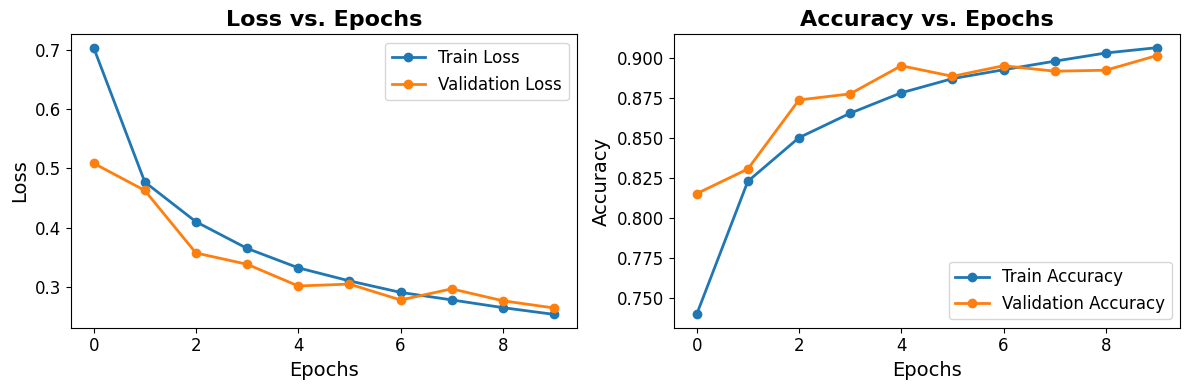

In [8]:
plot_training(history)

### 3.3. CNN in `pytorch_lightning` for a more realistic dataset

- A more realistic dataset: [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/data)
    - Colored JPEG images, **different sizes**
    - Not nicely centered, translation invariance is important
- **Preprocessing**
    - Decode JPEG images to floating-point tensors
    - Rescale pixel values to [0,1]
    - Resize images to 150x150 pixels

In [ ]:
""" 
下载猫狗大战的数据: https://www.kaggle.com/c/dogs-vs-cats/data
--- 将 `train.zip` 里的所有图片解压到 `original_dataset_dir` 路径下
--- 选择`original_dataset_dir`的一部分图片, 建立 训练集 和 验证集, 并存放在 `data_dir` 路径下
"""

""" 
import os, shutil 
import random

original_dataset_dir = '../Data/cats-vs-dogs'
data_dir = '../Data/cats-vs-dogs_small'

# The directory where we will
# store our smaller dataset
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(validation_cats_dir)
    os.mkdir(validation_dogs_dir)

# Copy first 2000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2000, 3000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 2000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2000, 3000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
"""

#### 3.3.1 Data Preprocessing & Data Loading

We create a Pytorch Lightning `DataModule` to do preprocessing and data loading


``` python
class ImageDataModule(pl.LightningDataModule):
  def __init__(self, data_dir, batch_size=20, img_size=(150, 150)):
    super().__init__()
    self.transform = transforms.Compose([
      transforms.Resize(self.img_size),  # Resize to 150x150
      transforms.ToTensor()])  # Convert to tensor (also scales 0-1)
  def setup(self, stage=None):
    self.train_dataset = datasets.ImageFolder(root=train_dir, transform=self.transform)
    self.val_dataset = datasets.ImageFolder(root=val_dir, transform=self.transform)
```
``` python
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
```

Seed set to 42


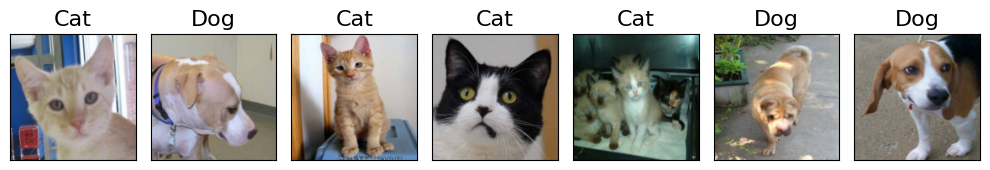

In [2]:
import random
import os


# Set random seed for reproducibility
def seed_everything(seed=42):

    """ 
    seed_everything 函数接受一个种子值, 并将其用于多个库(如PyTorch, NumPy)
    来确保每次运行代码时生成的随机数相同, 从而达到可重复的实验结果
    """
    pl.seed_everything(seed)  # Sets seed for PyTorch Lightning
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed_all(seed)  # CUDA (if available)
    np.random.seed(seed)  # NumPy
    random.seed(seed)  # Python random module
    torch.backends.cudnn.deterministic = True  # Ensures reproducibility in CNNs
    torch.backends.cudnn.benchmark = False  # Ensures consistency

seed_everything(42)  # Set global seed

class CatDataModule(pl.LightningDataModule):
    """ 
    加载和处理图像数据
    """
    def __init__(self, data_dir, batch_size=20, img_size=(150, 150)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size

        # Define image transformations
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),  # Resize to 150x150
            transforms.ToTensor(),  # Convert to tensor (also scales 0-1)
        ])

    def setup(self, stage=None):
        """Load datasets"""
        train_dir = os.path.join(self.data_dir, "train")
        val_dir = os.path.join(self.data_dir, "validation")

        self.train_dataset = datasets.ImageFolder(root=train_dir, transform=self.transform)
        self.val_dataset = datasets.ImageFolder(root=val_dir, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, persistent_workers=True)

# ----------------------------
# Load dataset and visualize a batch
# ----------------------------
data_dir = '../Data/cats-vs-dogs_small'
data_module = CatDataModule(data_dir=data_dir)
data_module.setup()
train_loader = data_module.train_dataloader()

# Get a batch of data and vis it
data_batch, labels_batch = next(iter(train_loader))

# Visualize images
plt.figure(figsize=(10, 5))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data_batch[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title("Cat" if labels_batch[i] == 0 else "Dog", fontsize=16)
plt.tight_layout()
plt.show()